In [1]:
# https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

In [2]:
import os
import sys
import time
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

import torchvision
import torchvision.transforms as transforms

sys.path.append('../')
from models.vit import *
from utils.train import train_one_epoch, get_acc

/home/beomgon/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42) # Seed 고정

In [4]:
from utils.train import get_args_parser
args = get_args_parser().parse_args(args=[])

In [5]:
args.lr = 0.00001
args.lr_scheduler = 'cosineannealinglr'
args.lr_warmup_epochs = 10
args.lr_warmup_method = 'linear'
args.auto_augment = 'ta_wide'
args.epochs = 300
args.random_erase = 0.1
args.weight_decay = 2e-5
args.norm_weight_decay = 0.
args.label_smoothing = 0.1
args.mixup_alpha = 0.2
args.cutmix_alpha = 1.
args.model_ema = True
args.workers = os.cpu_count()
args.saved = '../saved/cifar_vit_32_v2.pth'
args.device = 'cuda'
device = torch.device(args.device)

In [6]:
# args

In [7]:
train_transforms = transforms.Compose([
                    transforms.ColorJitter(0.1,0.1,0.1,0.1),
                    transforms.RandomHorizontalFlip(0.5),
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
test_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
train_dataset = torchvision.datasets.CIFAR10('../dataset', train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.CIFAR10('../dataset', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
from utils import transforms
collate_fn = None
num_classes = 10
mixup_transforms = []
if args.mixup_alpha > 0.0:
    mixup_transforms.append(transforms.RandomMixup(num_classes, p=1.0, alpha=args.mixup_alpha))
if args.cutmix_alpha > 0.0:
    mixup_transforms.append(transforms.RandomCutmix(num_classes, p=1.0, alpha=args.cutmix_alpha))
if mixup_transforms:
    mixupcutmix = torchvision.transforms.RandomChoice(mixup_transforms)

    def collate_fn(batch):
        return mixupcutmix(*default_collate(batch))

In [9]:
data_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    # sampler=train_sampler,
    shuffle=True,
    num_workers=args.workers,
    pin_memory=True,
    collate_fn=collate_fn,
)
data_loader_test = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False, num_workers=args.workers, pin_memory=True
)

In [10]:
img_size = 32
model_args = dict(img_size=img_size, 
                  patch_size=8, 
                  embed_dim=192, 
                  depth=12, 
                  num_heads=2, 
                  checkpoint='', 
                  qk_norm=True, 
                  v_norm=True, 
                  patch_stride=4,
                  roll=False)
model =  vit_small_patch8_32(**model_args)
model.to(device)
''

''

In [11]:
 criterion = nn.CrossEntropyLoss(label_smoothing=args.label_smoothing)

In [12]:
from utils import utils
custom_keys_weight_decay = []
if args.bias_weight_decay is not None:
    custom_keys_weight_decay.append(("bias", args.bias_weight_decay))
if args.transformer_embedding_decay is not None:
    for key in ["class_token", "position_embedding", "relative_position_bias_table"]:
        custom_keys_weight_decay.append((key, args.transformer_embedding_decay))
parameters = utils.set_weight_decay(
    model,
    args.weight_decay,
    norm_weight_decay=args.norm_weight_decay,
    custom_keys_weight_decay=custom_keys_weight_decay if len(custom_keys_weight_decay) > 0 else None,
)

In [13]:
optimizer = torch.optim.SGD(
    parameters,
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=args.weight_decay
)

In [14]:
scaler = torch.cuda.amp.GradScaler() if args.amp else None

In [15]:
from utils.scheduler import CosineAnnealingWarmUpRestarts
lr_scheduler = CosineAnnealingWarmUpRestarts(optimizer, T_0=50, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)

# main_lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#             optimizer, T_max=args.epochs - args.lr_warmup_epochs, eta_min=args.lr_min
#         )

In [16]:
# if args.lr_warmup_epochs > 0:
#     warmup_lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#         optimizer, start_factor=args.lr_warmup_decay, total_iters=args.lr_warmup_epochs
#     )
    
# lr_scheduler = torch.optim.lr_scheduler.SequentialLR(
#     optimizer, schedulers=[warmup_lr_scheduler, main_lr_scheduler], milestones=[args.lr_warmup_epochs]
# )    


In [17]:
model_ema = None
if args.model_ema:
    # Decay adjustment that aims to keep the decay independent of other hyper-parameters originally proposed at:
    # https://github.com/facebookresearch/pycls/blob/f8cd9627/pycls/core/net.py#L123
    #
    # total_ema_updates = (Dataset_size / n_GPUs) * epochs / (batch_size_per_gpu * EMA_steps)
    # We consider constant = Dataset_size for a given dataset/setup and omit it. Thus:
    # adjust = 1 / total_ema_updates ~= n_GPUs * batch_size_per_gpu * EMA_steps / epochs
    adjust = args.world_size * args.batch_size * args.model_ema_steps / args.epochs
    alpha = 1.0 - args.model_ema_decay
    alpha = min(1.0, alpha * adjust)
    model_ema = utils.ExponentialMovingAverage(model, device=device, decay=1.0 - alpha)
  

In [18]:
print("Start training")
start_time = time.time()
val_acc_list = []
best_acc = 0.
for epoch in tqdm(range(args.start_epoch, args.epochs)):
    train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, args, model_ema, scaler)
    lr_scheduler.step()
    acc = get_acc(data_loader_test, model, device)
    val_acc_list.append(acc)
    if best_acc < acc:
        best_acc = acc
        torch.save(model.state_dict(), args.saved)    
    if model_ema:
        acc_ema = get_acc(data_loader_test, model_ema, device)
    lr = optimizer.param_groups[0]['lr']
    print(f'{epoch + 1} acc: {acc:.2f} acc_ema {acc_ema:.2f} lr: {lr:.5f}')
total_time = time.time() - start_time
# print(f"Training time {total_time_str}")

Start training


  0%|▏                                        | 1/300 [00:44<3:42:09, 44.58s/it]

1 acc: 28.99 acc_ema 28.09 lr: 0.01001


  1%|▎                                        | 2/300 [01:27<3:37:01, 43.70s/it]

2 acc: 45.65 acc_ema 48.12 lr: 0.02001


  1%|▍                                        | 3/300 [02:11<3:37:30, 43.94s/it]

3 acc: 49.86 acc_ema 50.62 lr: 0.03001


  1%|▌                                        | 4/300 [02:56<3:37:58, 44.19s/it]

4 acc: 49.91 acc_ema 51.55 lr: 0.04001


  2%|▋                                        | 5/300 [03:40<3:36:18, 43.99s/it]

5 acc: 53.57 acc_ema 55.47 lr: 0.05001


  2%|▊                                        | 6/300 [04:22<3:33:24, 43.55s/it]

6 acc: 55.33 acc_ema 56.57 lr: 0.06000


  2%|▉                                        | 7/300 [05:08<3:35:26, 44.12s/it]

7 acc: 56.88 acc_ema 59.39 lr: 0.07000


  3%|█                                        | 8/300 [05:51<3:34:22, 44.05s/it]

8 acc: 60.02 acc_ema 61.40 lr: 0.08000


  3%|█▏                                       | 9/300 [06:35<3:32:51, 43.89s/it]

9 acc: 60.55 acc_ema 61.54 lr: 0.09000


  3%|█▎                                      | 10/300 [07:18<3:31:15, 43.71s/it]

10 acc: 63.57 acc_ema 62.56 lr: 0.10000


  4%|█▍                                      | 11/300 [08:03<3:31:59, 44.01s/it]

11 acc: 66.65 acc_ema 63.82 lr: 0.09985


  4%|█▌                                      | 12/300 [08:48<3:33:13, 44.42s/it]

12 acc: 69.23 acc_ema 63.84 lr: 0.09938


  4%|█▋                                      | 13/300 [09:34<3:34:06, 44.76s/it]

13 acc: 68.75 acc_ema 63.97 lr: 0.09862


  5%|█▊                                      | 14/300 [10:17<3:30:29, 44.16s/it]

14 acc: 65.77 acc_ema 64.02 lr: 0.09755


  5%|██                                      | 15/300 [11:00<3:28:14, 43.84s/it]

15 acc: 70.12 acc_ema 64.14 lr: 0.09619


  5%|██▏                                     | 16/300 [11:45<3:29:14, 44.21s/it]

16 acc: 70.21 acc_ema 64.24 lr: 0.09455


  6%|██▎                                     | 17/300 [12:28<3:27:41, 44.04s/it]

17 acc: 70.43 acc_ema 64.38 lr: 0.09263


  6%|██▍                                     | 18/300 [13:11<3:24:36, 43.53s/it]

18 acc: 74.10 acc_ema 64.51 lr: 0.09045


  6%|██▌                                     | 19/300 [13:53<3:22:02, 43.14s/it]

19 acc: 73.48 acc_ema 64.68 lr: 0.08802


  7%|██▋                                     | 20/300 [14:37<3:23:01, 43.51s/it]

20 acc: 73.92 acc_ema 64.72 lr: 0.08536


  7%|██▊                                     | 21/300 [15:23<3:25:00, 44.09s/it]

21 acc: 73.19 acc_ema 64.82 lr: 0.08247


  7%|██▉                                     | 22/300 [16:06<3:22:14, 43.65s/it]

22 acc: 76.32 acc_ema 64.88 lr: 0.07939


  8%|███                                     | 23/300 [16:49<3:21:03, 43.55s/it]

23 acc: 75.35 acc_ema 64.93 lr: 0.07613


  8%|███▏                                    | 24/300 [17:31<3:18:45, 43.21s/it]

24 acc: 76.05 acc_ema 64.99 lr: 0.07270


  8%|███▎                                    | 25/300 [18:15<3:18:17, 43.26s/it]

25 acc: 77.11 acc_ema 65.05 lr: 0.06914


  9%|███▍                                    | 26/300 [18:58<3:17:54, 43.34s/it]

26 acc: 76.73 acc_ema 65.17 lr: 0.06545


  9%|███▌                                    | 27/300 [19:41<3:16:46, 43.25s/it]

27 acc: 77.89 acc_ema 65.28 lr: 0.06168


  9%|███▋                                    | 28/300 [20:26<3:17:38, 43.60s/it]

28 acc: 78.53 acc_ema 65.39 lr: 0.05783


 10%|███▊                                    | 29/300 [21:09<3:16:51, 43.58s/it]

29 acc: 78.65 acc_ema 65.43 lr: 0.05393


 10%|████                                    | 30/300 [21:53<3:15:57, 43.55s/it]

30 acc: 79.15 acc_ema 65.54 lr: 0.05001


 10%|████▏                                   | 31/300 [22:36<3:15:25, 43.59s/it]

31 acc: 79.25 acc_ema 65.64 lr: 0.04608


 11%|████▎                                   | 32/300 [23:20<3:14:59, 43.65s/it]

32 acc: 79.11 acc_ema 65.70 lr: 0.04218


 11%|████▍                                   | 33/300 [24:03<3:13:30, 43.49s/it]

33 acc: 80.61 acc_ema 65.74 lr: 0.03833


 11%|████▌                                   | 34/300 [24:46<3:11:25, 43.18s/it]

34 acc: 81.45 acc_ema 65.82 lr: 0.03456


 12%|████▋                                   | 35/300 [25:29<3:10:38, 43.16s/it]

35 acc: 80.44 acc_ema 65.96 lr: 0.03087


 12%|████▊                                   | 36/300 [26:12<3:09:32, 43.08s/it]

36 acc: 81.89 acc_ema 66.02 lr: 0.02731


 12%|████▉                                   | 37/300 [26:56<3:10:00, 43.35s/it]

37 acc: 81.70 acc_ema 66.07 lr: 0.02388


 13%|█████                                   | 38/300 [27:41<3:11:52, 43.94s/it]

38 acc: 82.41 acc_ema 66.19 lr: 0.02062


 13%|█████▏                                  | 39/300 [28:24<3:09:27, 43.55s/it]

39 acc: 82.68 acc_ema 66.23 lr: 0.01754


 13%|█████▎                                  | 40/300 [29:09<3:11:02, 44.09s/it]

40 acc: 82.96 acc_ema 66.32 lr: 0.01465


 14%|█████▍                                  | 41/300 [29:52<3:08:55, 43.77s/it]

41 acc: 83.73 acc_ema 66.38 lr: 0.01199


 14%|█████▌                                  | 42/300 [30:37<3:09:17, 44.02s/it]

42 acc: 83.75 acc_ema 66.41 lr: 0.00956


 14%|█████▋                                  | 43/300 [31:21<3:08:36, 44.03s/it]

43 acc: 83.94 acc_ema 66.45 lr: 0.00738


 15%|█████▊                                  | 44/300 [32:03<3:06:00, 43.60s/it]

44 acc: 84.24 acc_ema 66.50 lr: 0.00546


 15%|██████                                  | 45/300 [32:45<3:02:54, 43.04s/it]

45 acc: 84.46 acc_ema 66.57 lr: 0.00382


 15%|██████▏                                 | 46/300 [33:29<3:02:54, 43.21s/it]

46 acc: 84.52 acc_ema 66.66 lr: 0.00246


 16%|██████▎                                 | 47/300 [34:12<3:02:53, 43.37s/it]

47 acc: 84.44 acc_ema 66.70 lr: 0.00139


 16%|██████▍                                 | 48/300 [34:57<3:03:15, 43.63s/it]

48 acc: 84.88 acc_ema 66.75 lr: 0.00063


 16%|██████▌                                 | 49/300 [35:40<3:02:49, 43.70s/it]

49 acc: 84.95 acc_ema 66.78 lr: 0.00016


 17%|██████▋                                 | 50/300 [36:25<3:02:38, 43.83s/it]

50 acc: 84.84 acc_ema 66.88 lr: 0.00001


 17%|██████▊                                 | 51/300 [37:08<3:01:29, 43.73s/it]

51 acc: 84.82 acc_ema 66.96 lr: 0.00501


 17%|██████▉                                 | 52/300 [37:53<3:02:38, 44.19s/it]

52 acc: 84.36 acc_ema 67.06 lr: 0.01001


 18%|███████                                 | 53/300 [38:37<3:01:09, 44.01s/it]

53 acc: 84.13 acc_ema 67.16 lr: 0.01501


 18%|███████▏                                | 54/300 [39:22<3:01:23, 44.24s/it]

54 acc: 82.91 acc_ema 67.24 lr: 0.02001


 18%|███████▎                                | 55/300 [40:05<2:59:45, 44.02s/it]

55 acc: 82.61 acc_ema 67.31 lr: 0.02500


 19%|███████▍                                | 56/300 [40:50<3:00:06, 44.29s/it]

56 acc: 81.75 acc_ema 67.38 lr: 0.03000


 19%|███████▌                                | 57/300 [41:33<2:57:39, 43.87s/it]

57 acc: 81.06 acc_ema 67.44 lr: 0.03500


 19%|███████▋                                | 58/300 [42:17<2:56:47, 43.83s/it]

58 acc: 79.95 acc_ema 67.58 lr: 0.04000


 20%|███████▊                                | 59/300 [43:01<2:56:30, 43.94s/it]

59 acc: 81.10 acc_ema 67.62 lr: 0.04500


 20%|████████                                | 60/300 [43:44<2:55:16, 43.82s/it]

60 acc: 81.84 acc_ema 67.67 lr: 0.05000


 20%|████████▏                               | 61/300 [44:29<2:54:53, 43.91s/it]

61 acc: 80.76 acc_ema 67.76 lr: 0.04992


 21%|████████▎                               | 62/300 [45:13<2:55:10, 44.16s/it]

62 acc: 79.67 acc_ema 67.81 lr: 0.04969


 21%|████████▍                               | 63/300 [45:58<2:55:10, 44.35s/it]

63 acc: 81.00 acc_ema 67.87 lr: 0.04931


 21%|████████▌                               | 64/300 [46:42<2:54:01, 44.24s/it]

64 acc: 80.52 acc_ema 67.93 lr: 0.04878


 22%|████████▋                               | 65/300 [47:25<2:51:31, 43.79s/it]

65 acc: 80.65 acc_ema 68.02 lr: 0.04810


 22%|████████▊                               | 66/300 [48:08<2:50:03, 43.60s/it]

66 acc: 80.26 acc_ema 68.06 lr: 0.04728


 22%|████████▉                               | 67/300 [48:52<2:49:38, 43.69s/it]

67 acc: 81.29 acc_ema 68.13 lr: 0.04632


 23%|█████████                               | 68/300 [49:37<2:50:24, 44.07s/it]

68 acc: 82.09 acc_ema 68.15 lr: 0.04523


 23%|█████████▏                              | 69/300 [50:22<2:50:25, 44.27s/it]

69 acc: 80.03 acc_ema 68.16 lr: 0.04401


 23%|█████████▎                              | 70/300 [51:04<2:48:06, 43.85s/it]

70 acc: 81.15 acc_ema 68.24 lr: 0.04268


 24%|█████████▍                              | 71/300 [51:49<2:48:33, 44.17s/it]

71 acc: 81.71 acc_ema 68.38 lr: 0.04124


 24%|█████████▌                              | 72/300 [52:33<2:46:55, 43.93s/it]

72 acc: 81.33 acc_ema 68.42 lr: 0.03970


 24%|█████████▋                              | 73/300 [53:16<2:45:36, 43.78s/it]

73 acc: 83.48 acc_ema 68.50 lr: 0.03806


 25%|█████████▊                              | 74/300 [54:01<2:46:31, 44.21s/it]

74 acc: 82.28 acc_ema 68.61 lr: 0.03635


 25%|██████████                              | 75/300 [54:45<2:44:37, 43.90s/it]

75 acc: 82.80 acc_ema 68.66 lr: 0.03457


 25%|██████████▏                             | 76/300 [55:27<2:42:24, 43.50s/it]

76 acc: 82.34 acc_ema 68.79 lr: 0.03273


 26%|██████████▎                             | 77/300 [56:11<2:41:50, 43.54s/it]

77 acc: 83.45 acc_ema 68.85 lr: 0.03084


 26%|██████████▍                             | 78/300 [56:56<2:42:54, 44.03s/it]

78 acc: 83.77 acc_ema 68.90 lr: 0.02892


 26%|██████████▌                             | 79/300 [57:40<2:41:49, 43.93s/it]

79 acc: 84.11 acc_ema 68.99 lr: 0.02697


 27%|██████████▋                             | 80/300 [58:23<2:40:40, 43.82s/it]

80 acc: 83.41 acc_ema 69.07 lr: 0.02500


 27%|██████████▊                             | 81/300 [59:08<2:41:00, 44.11s/it]

81 acc: 84.57 acc_ema 69.11 lr: 0.02304


 27%|██████████▉                             | 82/300 [59:52<2:40:08, 44.08s/it]

82 acc: 84.17 acc_ema 69.14 lr: 0.02109


 28%|██████████▌                           | 83/300 [1:00:36<2:39:36, 44.13s/it]

83 acc: 85.23 acc_ema 69.23 lr: 0.01917


 28%|██████████▋                           | 84/300 [1:01:20<2:38:13, 43.95s/it]

84 acc: 85.10 acc_ema 69.33 lr: 0.01728


 28%|██████████▊                           | 85/300 [1:02:03<2:36:58, 43.81s/it]

85 acc: 84.66 acc_ema 69.41 lr: 0.01544


 29%|██████████▉                           | 86/300 [1:02:48<2:36:53, 43.99s/it]

86 acc: 85.48 acc_ema 69.45 lr: 0.01366


 29%|███████████                           | 87/300 [1:03:31<2:35:09, 43.71s/it]

87 acc: 85.77 acc_ema 69.51 lr: 0.01195


 29%|███████████▏                          | 88/300 [1:04:14<2:33:36, 43.47s/it]

88 acc: 85.70 acc_ema 69.57 lr: 0.01031


 30%|███████████▎                          | 89/300 [1:04:56<2:32:11, 43.28s/it]

89 acc: 86.23 acc_ema 69.65 lr: 0.00877


 30%|███████████▍                          | 90/300 [1:05:41<2:32:53, 43.68s/it]

90 acc: 86.43 acc_ema 69.68 lr: 0.00733


 30%|███████████▌                          | 91/300 [1:06:23<2:30:29, 43.20s/it]

91 acc: 86.53 acc_ema 69.80 lr: 0.00600


 31%|███████████▋                          | 92/300 [1:07:06<2:29:14, 43.05s/it]

92 acc: 86.59 acc_ema 69.92 lr: 0.00478


 31%|███████████▊                          | 93/300 [1:07:50<2:30:06, 43.51s/it]

93 acc: 87.00 acc_ema 69.97 lr: 0.00369


 31%|███████████▉                          | 94/300 [1:08:33<2:27:58, 43.10s/it]

94 acc: 87.14 acc_ema 70.07 lr: 0.00273


 32%|████████████                          | 95/300 [1:09:16<2:27:26, 43.15s/it]

95 acc: 86.90 acc_ema 70.14 lr: 0.00191


 32%|████████████▏                         | 96/300 [1:10:00<2:27:27, 43.37s/it]

96 acc: 87.07 acc_ema 70.20 lr: 0.00123


 32%|████████████▎                         | 97/300 [1:10:43<2:26:29, 43.30s/it]

97 acc: 87.19 acc_ema 70.24 lr: 0.00070


 33%|████████████▍                         | 98/300 [1:11:26<2:25:34, 43.24s/it]

98 acc: 87.28 acc_ema 70.35 lr: 0.00032


 33%|████████████▌                         | 99/300 [1:12:09<2:24:14, 43.06s/it]

99 acc: 87.12 acc_ema 70.50 lr: 0.00009


 33%|████████████▎                        | 100/300 [1:12:51<2:23:09, 42.95s/it]

100 acc: 87.14 acc_ema 70.57 lr: 0.00001


 34%|████████████▍                        | 101/300 [1:13:34<2:22:14, 42.89s/it]

101 acc: 87.18 acc_ema 70.63 lr: 0.00251


 34%|████████████▌                        | 102/300 [1:14:18<2:22:35, 43.21s/it]

102 acc: 87.05 acc_ema 70.68 lr: 0.00501


 34%|████████████▋                        | 103/300 [1:15:01<2:22:08, 43.29s/it]

103 acc: 86.83 acc_ema 70.72 lr: 0.00751


 35%|████████████▊                        | 104/300 [1:15:44<2:20:48, 43.11s/it]

104 acc: 86.81 acc_ema 70.73 lr: 0.01001


 35%|████████████▉                        | 105/300 [1:16:26<2:18:50, 42.72s/it]

105 acc: 86.77 acc_ema 70.79 lr: 0.01251


 35%|█████████████                        | 106/300 [1:17:10<2:19:06, 43.02s/it]

106 acc: 85.85 acc_ema 70.87 lr: 0.01500


 36%|█████████████▏                       | 107/300 [1:17:53<2:18:35, 43.09s/it]

107 acc: 85.34 acc_ema 70.99 lr: 0.01750


 36%|█████████████▎                       | 108/300 [1:18:37<2:18:19, 43.23s/it]

108 acc: 85.58 acc_ema 71.08 lr: 0.02000


 36%|█████████████▍                       | 109/300 [1:19:20<2:17:38, 43.24s/it]

109 acc: 85.28 acc_ema 71.14 lr: 0.02250


 37%|█████████████▌                       | 110/300 [1:20:02<2:15:45, 42.87s/it]

110 acc: 83.47 acc_ema 71.24 lr: 0.02500


 37%|█████████████▋                       | 111/300 [1:20:47<2:17:32, 43.66s/it]

111 acc: 83.72 acc_ema 71.28 lr: 0.02496


 37%|█████████████▊                       | 112/300 [1:21:30<2:16:20, 43.51s/it]

112 acc: 84.03 acc_ema 71.35 lr: 0.02485


 38%|█████████████▉                       | 113/300 [1:22:13<2:14:15, 43.08s/it]

113 acc: 83.98 acc_ema 71.47 lr: 0.02465


 38%|██████████████                       | 114/300 [1:22:56<2:13:41, 43.13s/it]

114 acc: 84.28 acc_ema 71.54 lr: 0.02439


 38%|██████████████▏                      | 115/300 [1:23:39<2:13:32, 43.31s/it]

115 acc: 83.56 acc_ema 71.57 lr: 0.02405


 39%|██████████████▎                      | 116/300 [1:24:22<2:11:37, 42.92s/it]

116 acc: 84.07 acc_ema 71.65 lr: 0.02364


 39%|██████████████▍                      | 117/300 [1:25:05<2:11:34, 43.14s/it]

117 acc: 83.75 acc_ema 71.70 lr: 0.02316


 39%|██████████████▌                      | 118/300 [1:25:49<2:11:53, 43.48s/it]

118 acc: 84.64 acc_ema 71.70 lr: 0.02261


 40%|██████████████▋                      | 119/300 [1:26:33<2:11:12, 43.50s/it]

119 acc: 84.17 acc_ema 71.72 lr: 0.02201


 40%|██████████████▊                      | 120/300 [1:27:19<2:12:21, 44.12s/it]

120 acc: 84.37 acc_ema 71.76 lr: 0.02134


 40%|██████████████▉                      | 121/300 [1:28:02<2:10:43, 43.82s/it]

121 acc: 85.03 acc_ema 71.88 lr: 0.02062


 41%|███████████████                      | 122/300 [1:28:46<2:10:27, 43.98s/it]

122 acc: 85.09 acc_ema 71.88 lr: 0.01985


 41%|███████████████▏                     | 123/300 [1:29:31<2:11:02, 44.42s/it]

123 acc: 84.57 acc_ema 71.87 lr: 0.01903


 41%|███████████████▎                     | 124/300 [1:30:15<2:09:33, 44.17s/it]

124 acc: 84.99 acc_ema 71.97 lr: 0.01818


 42%|███████████████▍                     | 125/300 [1:30:58<2:07:33, 43.73s/it]

125 acc: 84.41 acc_ema 72.01 lr: 0.01729


 42%|███████████████▌                     | 126/300 [1:31:40<2:05:47, 43.38s/it]

126 acc: 85.42 acc_ema 72.05 lr: 0.01637


 42%|███████████████▋                     | 127/300 [1:32:24<2:05:25, 43.50s/it]

127 acc: 85.79 acc_ema 72.09 lr: 0.01542


 43%|███████████████▊                     | 128/300 [1:33:09<2:05:33, 43.80s/it]

128 acc: 85.83 acc_ema 72.11 lr: 0.01446


 43%|███████████████▉                     | 129/300 [1:33:51<2:03:49, 43.44s/it]

129 acc: 85.08 acc_ema 72.13 lr: 0.01349


 43%|████████████████                     | 130/300 [1:34:35<2:03:03, 43.43s/it]

130 acc: 85.70 acc_ema 72.22 lr: 0.01251


 44%|████████████████▏                    | 131/300 [1:35:17<2:01:36, 43.17s/it]

131 acc: 86.56 acc_ema 72.21 lr: 0.01152


 44%|████████████████▎                    | 132/300 [1:36:01<2:01:12, 43.29s/it]

132 acc: 86.09 acc_ema 72.29 lr: 0.01055


 44%|████████████████▍                    | 133/300 [1:36:44<2:00:37, 43.34s/it]

133 acc: 86.83 acc_ema 72.36 lr: 0.00959


 45%|████████████████▌                    | 134/300 [1:37:28<2:00:05, 43.41s/it]

134 acc: 86.70 acc_ema 72.35 lr: 0.00864


 45%|████████████████▋                    | 135/300 [1:38:13<2:01:04, 44.03s/it]

135 acc: 86.74 acc_ema 72.42 lr: 0.00772


 45%|████████████████▊                    | 136/300 [1:38:57<2:00:00, 43.90s/it]

136 acc: 86.75 acc_ema 72.50 lr: 0.00683


 46%|████████████████▉                    | 137/300 [1:39:40<1:58:55, 43.78s/it]

137 acc: 87.49 acc_ema 72.53 lr: 0.00598


 46%|█████████████████                    | 138/300 [1:40:23<1:57:12, 43.41s/it]

138 acc: 87.66 acc_ema 72.60 lr: 0.00516


 46%|█████████████████▏                   | 139/300 [1:41:09<1:58:31, 44.17s/it]

139 acc: 87.44 acc_ema 72.66 lr: 0.00439


 47%|█████████████████▎                   | 140/300 [1:41:53<1:57:48, 44.18s/it]

140 acc: 87.68 acc_ema 72.74 lr: 0.00367


 47%|█████████████████▍                   | 141/300 [1:42:37<1:56:35, 44.00s/it]

141 acc: 87.61 acc_ema 72.78 lr: 0.00300


 47%|█████████████████▌                   | 142/300 [1:43:21<1:56:06, 44.09s/it]

142 acc: 87.57 acc_ema 72.82 lr: 0.00240


 48%|█████████████████▋                   | 143/300 [1:44:06<1:56:20, 44.46s/it]

143 acc: 87.91 acc_ema 72.90 lr: 0.00185


 48%|█████████████████▊                   | 144/300 [1:44:49<1:54:10, 43.91s/it]

144 acc: 87.69 acc_ema 72.94 lr: 0.00137


 48%|█████████████████▉                   | 145/300 [1:45:33<1:53:58, 44.12s/it]

145 acc: 87.80 acc_ema 72.99 lr: 0.00096


 49%|██████████████████                   | 146/300 [1:46:17<1:52:43, 43.92s/it]

146 acc: 87.78 acc_ema 73.02 lr: 0.00062


 49%|██████████████████▏                  | 147/300 [1:47:00<1:51:23, 43.68s/it]

147 acc: 87.77 acc_ema 73.06 lr: 0.00036


 49%|██████████████████▎                  | 148/300 [1:47:43<1:50:14, 43.52s/it]

148 acc: 87.84 acc_ema 73.08 lr: 0.00016


 50%|██████████████████▍                  | 149/300 [1:48:28<1:50:07, 43.76s/it]

149 acc: 87.72 acc_ema 73.14 lr: 0.00005


 50%|██████████████████▌                  | 150/300 [1:49:11<1:49:19, 43.73s/it]

150 acc: 87.90 acc_ema 73.22 lr: 0.00001


 50%|██████████████████▌                  | 151/300 [1:49:54<1:48:10, 43.56s/it]

151 acc: 87.79 acc_ema 73.25 lr: 0.00126


 51%|██████████████████▋                  | 152/300 [1:50:39<1:48:07, 43.83s/it]

152 acc: 87.88 acc_ema 73.29 lr: 0.00251


 51%|██████████████████▊                  | 153/300 [1:51:22<1:46:34, 43.50s/it]

153 acc: 87.60 acc_ema 73.33 lr: 0.00376


 51%|██████████████████▉                  | 154/300 [1:52:03<1:44:36, 42.99s/it]

154 acc: 87.64 acc_ema 73.38 lr: 0.00501


 52%|███████████████████                  | 155/300 [1:52:47<1:44:31, 43.25s/it]

155 acc: 87.52 acc_ema 73.46 lr: 0.00626


 52%|███████████████████▏                 | 156/300 [1:53:30<1:43:26, 43.10s/it]

156 acc: 87.54 acc_ema 73.54 lr: 0.00750


 52%|███████████████████▎                 | 157/300 [1:54:13<1:42:25, 42.98s/it]

157 acc: 87.00 acc_ema 73.53 lr: 0.00875


 53%|███████████████████▍                 | 158/300 [1:54:57<1:42:32, 43.33s/it]

158 acc: 86.91 acc_ema 73.59 lr: 0.01000


 53%|███████████████████▌                 | 159/300 [1:55:41<1:42:26, 43.59s/it]

159 acc: 86.79 acc_ema 73.61 lr: 0.01125


 53%|███████████████████▋                 | 160/300 [1:56:24<1:41:27, 43.49s/it]

160 acc: 86.86 acc_ema 73.64 lr: 0.01250


 54%|███████████████████▊                 | 161/300 [1:57:06<1:39:53, 43.12s/it]

161 acc: 86.58 acc_ema 73.72 lr: 0.01248


 54%|███████████████████▉                 | 162/300 [1:57:50<1:39:40, 43.34s/it]

162 acc: 85.24 acc_ema 73.74 lr: 0.01242


 54%|████████████████████                 | 163/300 [1:58:34<1:39:15, 43.47s/it]

163 acc: 86.41 acc_ema 73.79 lr: 0.01233


 55%|████████████████████▏                | 164/300 [1:59:17<1:38:16, 43.36s/it]

164 acc: 87.07 acc_ema 73.82 lr: 0.01219


 55%|████████████████████▎                | 165/300 [2:00:01<1:37:41, 43.42s/it]

165 acc: 86.79 acc_ema 73.87 lr: 0.01202


 55%|████████████████████▍                | 166/300 [2:00:45<1:37:44, 43.77s/it]

166 acc: 85.62 acc_ema 73.88 lr: 0.01182


 56%|████████████████████▌                | 167/300 [2:01:28<1:36:21, 43.47s/it]

167 acc: 85.98 acc_ema 73.90 lr: 0.01158


 56%|████████████████████▋                | 168/300 [2:02:11<1:35:29, 43.41s/it]

168 acc: 85.96 acc_ema 73.89 lr: 0.01131


 56%|████████████████████▊                | 169/300 [2:02:56<1:35:16, 43.64s/it]

169 acc: 86.00 acc_ema 73.98 lr: 0.01100


 57%|████████████████████▉                | 170/300 [2:03:38<1:33:54, 43.34s/it]

170 acc: 86.31 acc_ema 74.00 lr: 0.01067


 57%|█████████████████████                | 171/300 [2:04:23<1:33:59, 43.72s/it]

171 acc: 86.32 acc_ema 74.00 lr: 0.01031


 57%|█████████████████████▏               | 172/300 [2:05:07<1:33:32, 43.85s/it]

172 acc: 86.63 acc_ema 74.13 lr: 0.00993


 58%|█████████████████████▎               | 173/300 [2:05:54<1:34:37, 44.71s/it]

173 acc: 86.23 acc_ema 74.20 lr: 0.00952


 58%|█████████████████████▍               | 174/300 [2:06:38<1:33:20, 44.45s/it]

174 acc: 86.21 acc_ema 74.20 lr: 0.00909


 58%|█████████████████████▌               | 175/300 [2:07:20<1:31:38, 43.99s/it]

175 acc: 86.67 acc_ema 74.24 lr: 0.00864


 59%|█████████████████████▋               | 176/300 [2:08:04<1:30:45, 43.92s/it]

176 acc: 86.77 acc_ema 74.28 lr: 0.00818


 59%|█████████████████████▊               | 177/300 [2:08:47<1:29:34, 43.69s/it]

177 acc: 87.15 acc_ema 74.35 lr: 0.00771


 59%|█████████████████████▉               | 178/300 [2:09:30<1:28:27, 43.50s/it]

178 acc: 86.82 acc_ema 74.42 lr: 0.00723


 60%|██████████████████████               | 179/300 [2:10:15<1:28:10, 43.72s/it]

179 acc: 87.23 acc_ema 74.49 lr: 0.00674


 60%|██████████████████████▏              | 180/300 [2:10:59<1:27:41, 43.84s/it]

180 acc: 87.33 acc_ema 74.55 lr: 0.00626


 60%|██████████████████████▎              | 181/300 [2:11:43<1:26:54, 43.82s/it]

181 acc: 86.93 acc_ema 74.61 lr: 0.00577


 61%|██████████████████████▍              | 182/300 [2:12:26<1:25:47, 43.62s/it]

182 acc: 87.12 acc_ema 74.65 lr: 0.00528


 61%|██████████████████████▌              | 183/300 [2:13:11<1:25:49, 44.01s/it]

183 acc: 87.69 acc_ema 74.68 lr: 0.00480


 61%|██████████████████████▋              | 184/300 [2:13:55<1:25:03, 43.99s/it]

184 acc: 87.39 acc_ema 74.69 lr: 0.00433


 62%|██████████████████████▊              | 185/300 [2:14:39<1:24:37, 44.15s/it]

185 acc: 87.75 acc_ema 74.70 lr: 0.00387


 62%|██████████████████████▉              | 186/300 [2:15:21<1:22:53, 43.62s/it]

186 acc: 87.74 acc_ema 74.75 lr: 0.00342


 62%|███████████████████████              | 187/300 [2:16:08<1:23:32, 44.36s/it]

187 acc: 87.56 acc_ema 74.78 lr: 0.00299


 63%|███████████████████████▏             | 188/300 [2:16:51<1:22:06, 43.99s/it]

188 acc: 87.50 acc_ema 74.83 lr: 0.00258


 63%|███████████████████████▎             | 189/300 [2:17:33<1:20:32, 43.54s/it]

189 acc: 87.47 acc_ema 74.86 lr: 0.00220


 63%|███████████████████████▍             | 190/300 [2:18:17<1:20:14, 43.77s/it]

190 acc: 87.77 acc_ema 74.85 lr: 0.00184


 64%|███████████████████████▌             | 191/300 [2:19:00<1:18:55, 43.45s/it]

191 acc: 87.67 acc_ema 74.90 lr: 0.00151


 64%|███████████████████████▋             | 192/300 [2:19:43<1:17:41, 43.16s/it]

192 acc: 87.93 acc_ema 74.95 lr: 0.00120


 64%|███████████████████████▊             | 193/300 [2:20:25<1:16:44, 43.03s/it]

193 acc: 88.21 acc_ema 74.99 lr: 0.00093


 65%|███████████████████████▉             | 194/300 [2:21:09<1:16:22, 43.23s/it]

194 acc: 88.05 acc_ema 75.05 lr: 0.00069


 65%|████████████████████████             | 195/300 [2:21:53<1:15:59, 43.43s/it]

195 acc: 88.06 acc_ema 75.06 lr: 0.00049


 65%|████████████████████████▏            | 196/300 [2:22:38<1:16:03, 43.88s/it]

196 acc: 88.03 acc_ema 75.06 lr: 0.00032


 66%|████████████████████████▎            | 197/300 [2:23:23<1:15:52, 44.20s/it]

197 acc: 87.72 acc_ema 75.17 lr: 0.00018


 66%|████████████████████████▍            | 198/300 [2:24:07<1:14:53, 44.06s/it]

198 acc: 88.00 acc_ema 75.22 lr: 0.00009


 66%|████████████████████████▌            | 199/300 [2:24:49<1:13:35, 43.71s/it]

199 acc: 88.12 acc_ema 75.26 lr: 0.00003


 67%|████████████████████████▋            | 200/300 [2:25:32<1:12:01, 43.22s/it]

200 acc: 88.17 acc_ema 75.31 lr: 0.00001


 67%|████████████████████████▊            | 201/300 [2:26:16<1:11:46, 43.50s/it]

201 acc: 87.99 acc_ema 75.37 lr: 0.00063


 67%|████████████████████████▉            | 202/300 [2:27:00<1:11:17, 43.65s/it]

202 acc: 87.90 acc_ema 75.42 lr: 0.00126


 68%|█████████████████████████            | 203/300 [2:27:45<1:11:21, 44.14s/it]

203 acc: 88.01 acc_ema 75.46 lr: 0.00188


 68%|█████████████████████████▏           | 204/300 [2:28:28<1:10:10, 43.86s/it]

204 acc: 87.64 acc_ema 75.50 lr: 0.00251


 68%|█████████████████████████▎           | 205/300 [2:29:11<1:08:57, 43.55s/it]

205 acc: 87.79 acc_ema 75.55 lr: 0.00313


 69%|█████████████████████████▍           | 206/300 [2:29:54<1:08:03, 43.44s/it]

206 acc: 87.96 acc_ema 75.56 lr: 0.00375


 69%|█████████████████████████▌           | 207/300 [2:30:37<1:07:08, 43.31s/it]

207 acc: 87.75 acc_ema 75.64 lr: 0.00438


 69%|█████████████████████████▋           | 208/300 [2:31:21<1:06:24, 43.31s/it]

208 acc: 87.52 acc_ema 75.65 lr: 0.00500


 70%|█████████████████████████▊           | 209/300 [2:32:05<1:06:25, 43.80s/it]

209 acc: 87.21 acc_ema 75.70 lr: 0.00563


 70%|█████████████████████████▉           | 210/300 [2:32:49<1:05:40, 43.79s/it]

210 acc: 87.44 acc_ema 75.74 lr: 0.00625


 70%|██████████████████████████           | 211/300 [2:33:32<1:04:32, 43.51s/it]

211 acc: 87.47 acc_ema 75.77 lr: 0.00624


 71%|██████████████████████████▏          | 212/300 [2:34:15<1:03:45, 43.47s/it]

212 acc: 87.21 acc_ema 75.82 lr: 0.00621


 71%|██████████████████████████▎          | 213/300 [2:34:59<1:02:57, 43.42s/it]

213 acc: 87.21 acc_ema 75.85 lr: 0.00616


 71%|██████████████████████████▍          | 214/300 [2:35:43<1:02:33, 43.64s/it]

214 acc: 87.36 acc_ema 75.86 lr: 0.00610


 72%|██████████████████████████▌          | 215/300 [2:36:26<1:01:40, 43.54s/it]

215 acc: 87.43 acc_ema 75.88 lr: 0.00601


 72%|██████████████████████████▋          | 216/300 [2:37:10<1:01:06, 43.65s/it]

216 acc: 87.50 acc_ema 75.89 lr: 0.00591


 72%|██████████████████████████▊          | 217/300 [2:37:53<1:00:03, 43.42s/it]

217 acc: 87.30 acc_ema 75.95 lr: 0.00579


 73%|████████████████████████████▎          | 218/300 [2:38:35<58:37, 42.90s/it]

218 acc: 87.58 acc_ema 76.00 lr: 0.00565


 73%|████████████████████████████▍          | 219/300 [2:39:17<57:44, 42.77s/it]

219 acc: 87.13 acc_ema 76.07 lr: 0.00550


 73%|████████████████████████████▌          | 220/300 [2:40:00<57:09, 42.87s/it]

220 acc: 87.00 acc_ema 76.12 lr: 0.00534


 74%|████████████████████████████▋          | 221/300 [2:40:45<57:05, 43.36s/it]

221 acc: 87.91 acc_ema 76.17 lr: 0.00516


 74%|████████████████████████████▊          | 222/300 [2:41:29<56:47, 43.69s/it]

222 acc: 87.42 acc_ema 76.22 lr: 0.00496


 74%|████████████████████████████▉          | 223/300 [2:42:12<55:50, 43.51s/it]

223 acc: 87.41 acc_ema 76.28 lr: 0.00476


 75%|█████████████████████████████          | 224/300 [2:42:56<55:02, 43.46s/it]

224 acc: 87.23 acc_ema 76.33 lr: 0.00455


 75%|█████████████████████████████▎         | 225/300 [2:43:39<54:19, 43.45s/it]

225 acc: 87.32 acc_ema 76.36 lr: 0.00432


 75%|█████████████████████████████▍         | 226/300 [2:44:22<53:33, 43.43s/it]

226 acc: 87.51 acc_ema 76.36 lr: 0.00409


 76%|█████████████████████████████▌         | 227/300 [2:45:06<52:55, 43.50s/it]

227 acc: 87.44 acc_ema 76.37 lr: 0.00386


 76%|█████████████████████████████▋         | 228/300 [2:45:48<51:41, 43.08s/it]

228 acc: 87.43 acc_ema 76.36 lr: 0.00362


 76%|█████████████████████████████▊         | 229/300 [2:46:32<51:08, 43.22s/it]

229 acc: 87.43 acc_ema 76.38 lr: 0.00337


 77%|█████████████████████████████▉         | 230/300 [2:47:15<50:28, 43.27s/it]

230 acc: 87.46 acc_ema 76.45 lr: 0.00313


 77%|██████████████████████████████         | 231/300 [2:47:57<49:15, 42.83s/it]

231 acc: 87.53 acc_ema 76.46 lr: 0.00289


 77%|██████████████████████████████▏        | 232/300 [2:48:41<48:54, 43.16s/it]

232 acc: 87.83 acc_ema 76.51 lr: 0.00264


 78%|██████████████████████████████▎        | 233/300 [2:49:25<48:40, 43.58s/it]

233 acc: 88.17 acc_ema 76.53 lr: 0.00240


 78%|██████████████████████████████▍        | 234/300 [2:50:08<47:32, 43.21s/it]

234 acc: 87.83 acc_ema 76.59 lr: 0.00217


 78%|██████████████████████████████▌        | 235/300 [2:50:50<46:18, 42.75s/it]

235 acc: 87.80 acc_ema 76.65 lr: 0.00194


 79%|██████████████████████████████▋        | 236/300 [2:51:33<45:57, 43.08s/it]

236 acc: 87.49 acc_ema 76.70 lr: 0.00171


 79%|██████████████████████████████▊        | 237/300 [2:52:18<45:50, 43.66s/it]

237 acc: 87.34 acc_ema 76.75 lr: 0.00150


 79%|██████████████████████████████▉        | 238/300 [2:53:02<45:02, 43.59s/it]

238 acc: 87.88 acc_ema 76.78 lr: 0.00130


 80%|███████████████████████████████        | 239/300 [2:53:46<44:22, 43.66s/it]

239 acc: 87.99 acc_ema 76.80 lr: 0.00110


 80%|███████████████████████████████▏       | 240/300 [2:54:29<43:34, 43.58s/it]

240 acc: 87.89 acc_ema 76.83 lr: 0.00092


 80%|███████████████████████████████▎       | 241/300 [2:55:13<42:58, 43.70s/it]

241 acc: 87.98 acc_ema 76.92 lr: 0.00076


 81%|███████████████████████████████▍       | 242/300 [2:55:56<42:02, 43.50s/it]

242 acc: 88.23 acc_ema 76.98 lr: 0.00061


 81%|███████████████████████████████▌       | 243/300 [2:56:39<41:10, 43.33s/it]

243 acc: 88.12 acc_ema 77.01 lr: 0.00047


 81%|███████████████████████████████▋       | 244/300 [2:57:22<40:25, 43.31s/it]

244 acc: 88.21 acc_ema 77.03 lr: 0.00035


 82%|███████████████████████████████▊       | 245/300 [2:58:05<39:31, 43.11s/it]

245 acc: 88.19 acc_ema 77.06 lr: 0.00025


 82%|███████████████████████████████▉       | 246/300 [2:58:52<39:49, 44.25s/it]

246 acc: 88.21 acc_ema 77.09 lr: 0.00016


 82%|████████████████████████████████       | 247/300 [2:59:35<38:42, 43.82s/it]

247 acc: 88.20 acc_ema 77.12 lr: 0.00010


 83%|████████████████████████████████▏      | 248/300 [3:00:17<37:39, 43.46s/it]

248 acc: 88.21 acc_ema 77.15 lr: 0.00005


 83%|████████████████████████████████▎      | 249/300 [3:01:00<36:38, 43.11s/it]

249 acc: 88.12 acc_ema 77.24 lr: 0.00002


 83%|████████████████████████████████▌      | 250/300 [3:01:44<36:12, 43.45s/it]

250 acc: 88.08 acc_ema 77.29 lr: 0.00001


 84%|████████████████████████████████▋      | 251/300 [3:02:27<35:27, 43.43s/it]

251 acc: 88.16 acc_ema 77.33 lr: 0.00032


 84%|████████████████████████████████▊      | 252/300 [3:03:13<35:24, 44.25s/it]

252 acc: 88.09 acc_ema 77.39 lr: 0.00063


 84%|████████████████████████████████▉      | 253/300 [3:03:56<34:23, 43.91s/it]

253 acc: 88.09 acc_ema 77.40 lr: 0.00094


 85%|█████████████████████████████████      | 254/300 [3:04:40<33:33, 43.76s/it]

254 acc: 88.10 acc_ema 77.46 lr: 0.00126


 85%|█████████████████████████████████▏     | 255/300 [3:05:23<32:44, 43.65s/it]

255 acc: 87.91 acc_ema 77.49 lr: 0.00157


 85%|█████████████████████████████████▎     | 256/300 [3:06:07<31:57, 43.57s/it]

256 acc: 87.81 acc_ema 77.52 lr: 0.00188


 86%|█████████████████████████████████▍     | 257/300 [3:06:52<31:31, 43.99s/it]

257 acc: 87.98 acc_ema 77.57 lr: 0.00219


 86%|█████████████████████████████████▌     | 258/300 [3:07:35<30:38, 43.78s/it]

258 acc: 87.89 acc_ema 77.61 lr: 0.00250


 86%|█████████████████████████████████▋     | 259/300 [3:08:19<30:01, 43.93s/it]

259 acc: 88.10 acc_ema 77.69 lr: 0.00281


 87%|█████████████████████████████████▊     | 260/300 [3:09:03<29:16, 43.90s/it]

260 acc: 87.94 acc_ema 77.75 lr: 0.00313


 87%|█████████████████████████████████▉     | 261/300 [3:09:46<28:19, 43.59s/it]

261 acc: 87.66 acc_ema 77.79 lr: 0.00312


 87%|██████████████████████████████████     | 262/300 [3:10:30<27:38, 43.64s/it]

262 acc: 87.74 acc_ema 77.82 lr: 0.00311


 88%|██████████████████████████████████▏    | 263/300 [3:11:12<26:40, 43.27s/it]

263 acc: 87.54 acc_ema 77.88 lr: 0.00308


 88%|██████████████████████████████████▎    | 264/300 [3:11:58<26:28, 44.12s/it]

264 acc: 87.40 acc_ema 77.94 lr: 0.00305


 88%|██████████████████████████████████▍    | 265/300 [3:12:42<25:43, 44.09s/it]

265 acc: 87.74 acc_ema 77.96 lr: 0.00301


 89%|██████████████████████████████████▌    | 266/300 [3:13:25<24:49, 43.80s/it]

266 acc: 87.75 acc_ema 78.03 lr: 0.00296


 89%|██████████████████████████████████▋    | 267/300 [3:14:08<23:59, 43.61s/it]

267 acc: 87.73 acc_ema 78.08 lr: 0.00290


 89%|██████████████████████████████████▊    | 268/300 [3:14:53<23:20, 43.77s/it]

268 acc: 87.69 acc_ema 78.13 lr: 0.00283


 90%|██████████████████████████████████▉    | 269/300 [3:15:38<22:52, 44.28s/it]

269 acc: 87.78 acc_ema 78.13 lr: 0.00275


 90%|███████████████████████████████████    | 270/300 [3:16:23<22:18, 44.62s/it]

270 acc: 88.16 acc_ema 78.18 lr: 0.00267


 90%|███████████████████████████████████▏   | 271/300 [3:17:06<21:17, 44.05s/it]

271 acc: 87.85 acc_ema 78.23 lr: 0.00258


 91%|███████████████████████████████████▎   | 272/300 [3:17:50<20:29, 43.90s/it]

272 acc: 87.80 acc_ema 78.32 lr: 0.00248


 91%|███████████████████████████████████▍   | 273/300 [3:18:35<19:59, 44.44s/it]

273 acc: 87.89 acc_ema 78.39 lr: 0.00238


 91%|███████████████████████████████████▌   | 274/300 [3:19:20<19:16, 44.47s/it]

274 acc: 88.31 acc_ema 78.45 lr: 0.00227


 92%|███████████████████████████████████▊   | 275/300 [3:20:03<18:17, 43.90s/it]

275 acc: 87.69 acc_ema 78.51 lr: 0.00216


 92%|███████████████████████████████████▉   | 276/300 [3:20:48<17:41, 44.24s/it]

276 acc: 87.79 acc_ema 78.54 lr: 0.00205


 92%|████████████████████████████████████   | 277/300 [3:21:32<16:59, 44.32s/it]

277 acc: 87.55 acc_ema 78.54 lr: 0.00193


 93%|████████████████████████████████████▏  | 278/300 [3:22:14<15:58, 43.58s/it]

278 acc: 88.10 acc_ema 78.59 lr: 0.00181


 93%|████████████████████████████████████▎  | 279/300 [3:22:56<15:07, 43.23s/it]

279 acc: 87.84 acc_ema 78.63 lr: 0.00169


 93%|████████████████████████████████████▍  | 280/300 [3:23:39<14:19, 42.96s/it]

280 acc: 87.85 acc_ema 78.65 lr: 0.00157


 94%|████████████████████████████████████▌  | 281/300 [3:24:24<13:47, 43.55s/it]

281 acc: 88.22 acc_ema 78.64 lr: 0.00145


 94%|████████████████████████████████████▋  | 282/300 [3:25:07<13:00, 43.36s/it]

282 acc: 88.23 acc_ema 78.66 lr: 0.00132


 94%|████████████████████████████████████▊  | 283/300 [3:25:52<12:25, 43.86s/it]

283 acc: 87.99 acc_ema 78.69 lr: 0.00120


 95%|████████████████████████████████████▉  | 284/300 [3:26:35<11:37, 43.61s/it]

284 acc: 87.78 acc_ema 78.72 lr: 0.00109


 95%|█████████████████████████████████████  | 285/300 [3:27:17<10:49, 43.30s/it]

285 acc: 88.05 acc_ema 78.77 lr: 0.00097


 95%|█████████████████████████████████████▏ | 286/300 [3:28:00<10:02, 43.06s/it]

286 acc: 87.92 acc_ema 78.84 lr: 0.00086


 96%|█████████████████████████████████████▎ | 287/300 [3:28:43<09:22, 43.28s/it]

287 acc: 88.13 acc_ema 78.88 lr: 0.00075


 96%|█████████████████████████████████████▍ | 288/300 [3:29:28<08:42, 43.54s/it]

288 acc: 87.99 acc_ema 78.95 lr: 0.00065


 96%|█████████████████████████████████████▌ | 289/300 [3:30:12<08:03, 43.94s/it]

289 acc: 88.10 acc_ema 78.98 lr: 0.00056


 97%|█████████████████████████████████████▋ | 290/300 [3:30:57<07:20, 44.07s/it]

290 acc: 88.02 acc_ema 79.05 lr: 0.00047


 97%|█████████████████████████████████████▊ | 291/300 [3:31:41<06:37, 44.17s/it]

291 acc: 88.12 acc_ema 79.11 lr: 0.00038


 97%|█████████████████████████████████████▉ | 292/300 [3:32:27<05:57, 44.69s/it]

292 acc: 87.95 acc_ema 79.14 lr: 0.00031


 98%|██████████████████████████████████████ | 293/300 [3:33:11<05:10, 44.35s/it]

293 acc: 87.90 acc_ema 79.17 lr: 0.00024


 98%|██████████████████████████████████████▏| 294/300 [3:33:54<04:25, 44.18s/it]

294 acc: 88.01 acc_ema 79.25 lr: 0.00018


 98%|██████████████████████████████████████▎| 295/300 [3:34:39<03:41, 44.31s/it]

295 acc: 88.23 acc_ema 79.24 lr: 0.00013


 99%|██████████████████████████████████████▍| 296/300 [3:35:22<02:55, 43.82s/it]

296 acc: 87.99 acc_ema 79.28 lr: 0.00009


 99%|██████████████████████████████████████▌| 297/300 [3:36:07<02:12, 44.12s/it]

297 acc: 87.87 acc_ema 79.31 lr: 0.00005


 99%|██████████████████████████████████████▋| 298/300 [3:36:51<01:28, 44.28s/it]

298 acc: 87.92 acc_ema 79.36 lr: 0.00003


100%|██████████████████████████████████████▊| 299/300 [3:37:35<00:44, 44.03s/it]

299 acc: 87.87 acc_ema 79.39 lr: 0.00001


100%|███████████████████████████████████████| 300/300 [3:38:17<00:00, 43.66s/it]

300 acc: 87.98 acc_ema 79.43 lr: 0.00001


NameError: name 'total_time_str' is not defined

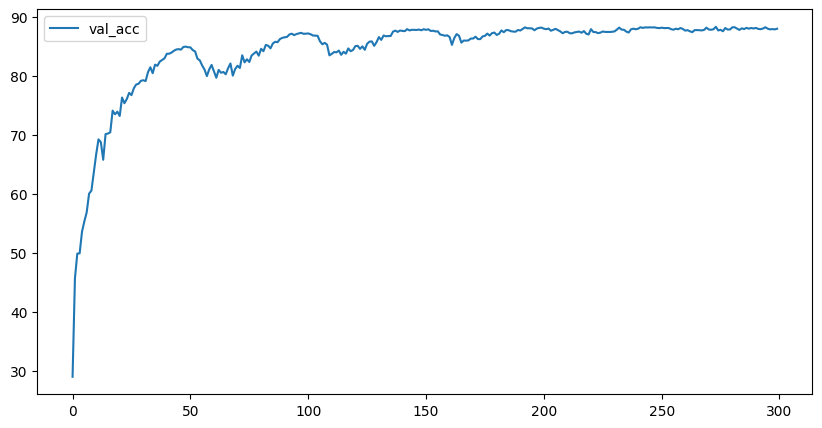

In [19]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,5]
plt.plot(val_acc_list, label='val_acc')
plt.legend()


In [20]:
from utils.train import get_all_preds
test_preds = get_all_preds(model.to('cpu'), data_loader_test)
actual_labels = torch.Tensor(test_dataset.targets)
preds_correct = test_preds.argmax(dim=1).eq(actual_labels).sum().item()

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(test_dataset))

total correct: 8798
accuracy: 0.8798


Confusion matrix, without normalization
[[904   9  26   7   5   4   1   6  26  12]
 [  5 952   3   2   1   2   1   1   5  28]
 [ 27   1 853  28  31  30  19   5   4   2]
 [ 11   2  23 717  36 163  29  15   2   2]
 [  7   0  36  20 864  21  21  30   1   0]
 [  2   0  21  87  17 847   9  15   1   1]
 [  5   1  35  20   8  11 914   0   4   2]
 [  4   2  16  20  21  31   1 905   0   0]
 [ 26   8   5   4   2   2   2   0 941  10]
 [ 11  52   7   7   0   4   1   3  14 901]]


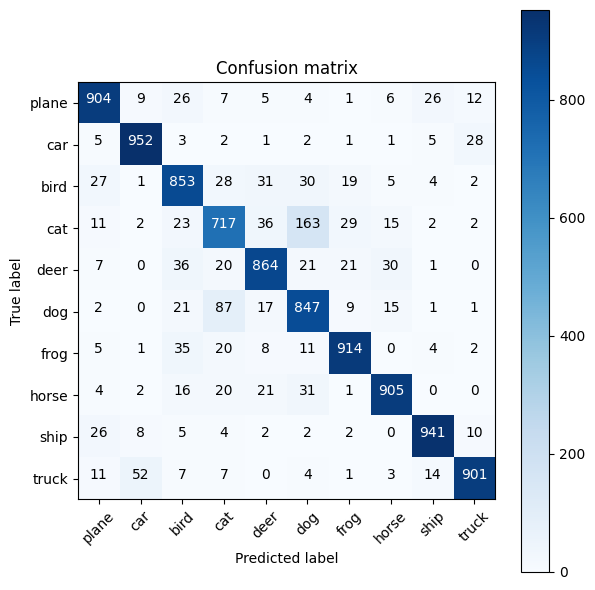

In [21]:
from utils.visualize import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_dataset.targets, test_preds.argmax(dim=1))
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, classes)